In [3]:
import numpy as np
import pandas as pd
import sys
import nltk
import re
import gensim
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim import corpora,models
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 

data=pd.read_csv('./abcnews-date-text.csv')
# take 5000 news as input data
data_samples=data['headline_text'][:5000]
data=data['headline_text'][:5000]

cleanedData = []
# print(data)
lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]

    
    cleanedData.append(text)
# print(cleanedData)

dictionary = corpora.Dictionary(cleanedData)
# print(dictionary)
# print(cleanedData)
corpus = [dictionary.doc2bow(text) for text in cleanedData]
# print(corpus)
print(dictionary[0])
print(dictionary[1])

aba
broadcasting


In [3]:
# print(corpus)
# tf_vectorizer = CountVectorizer(
#                                 max_features=10000,
#                                 stop_words='english')
# tf = tf_vectorizer.fit_transform(data_samples)
# vocabulary = tf_vectorizer.vocabulary_
# print(vocabulary)
# print(len(vocabulary))
# docs = []
# print(tf.toarray().shape)
# for row in tf.toarray():
#     present_words = np.where(row != 0)[0].tolist()
#     present_words_with_count = []
#     for word_idx in present_words:
#         for count in range(row[word_idx]):
#             present_words_with_count.append(word_idx)
#     docs.append(present_words_with_count)
# print(docs)
# print(len(docs))

# organize the document format as documents:[[word_id_11, word_id_12,...,word_id_1n],[word_id_21,...],]
present_words=[]
docs = []
for doc in corpus:
    present_words=[]
    for j in doc:
        present_words.append(j[0])
    docs.append(present_words)
print(docs)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22], [16, 18, 22, 23, 24, 25], [26, 27, 28, 29, 30], [31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42], [17, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52], [45, 48, 53, 54, 55, 56], [32, 35, 57, 58, 59, 60], [61, 62, 63, 64], [65, 66, 67, 68, 69], [64, 65, 70, 71, 72, 73], [74, 75, 76, 77, 78], [79, 80, 81, 82, 83], [83, 84, 85, 86, 87, 88], [30, 89, 90, 91, 92, 93], [94, 95, 96, 97, 98], [99, 100, 101, 102], [103, 104, 105, 106, 107, 108], [11, 61, 109, 110, 111, 112], [113, 114, 115, 116, 117, 118], [119, 120, 121], [122, 123, 124, 125, 126, 127], [128, 129, 130, 131, 132, 133, 134], [2, 97, 135, 136, 137], [44, 138, 139, 140, 141, 142], [143, 144, 145, 146], [44, 63, 147, 148, 149, 150], [44, 151, 152, 153, 154], [44, 154, 155, 156], [157, 158, 159, 160, 161, 162], [8, 20, 163, 164, 165], [166, 167, 168, 169, 170, 171, 172], [173, 174, 175, 176, 177], [178, 179, 180, 181, 182], [183, 184, 185, 186, 18

In [8]:
class LDA(object):
    
    def __init__(self,documents,vocabulary,K, max_iteration=1000):
        self.documents=documents
        # number of documents
        self.M=len(documents)
        self.vocabulary=vocabulary
        # number of unique words in documents
        self.V=len(self.vocabulary)
        print(self.V)
        # number of topics
        self.K = K
        # number of iterations in Gibbs sampling
        self.max_iteration = max_iteration
        # build the weight matrix for documents_topics, topic_words
        # Shape of documents_topics is M*K, Shape of topic_words is K*V
        # documents_sum_topics is the number of topics on each document
        # topics_sum_words is the number of words on each topic
        self.documents_topics=np.zeros((self.M,self.K))
        self.topics_words=np.zeros((self.K,self.V))
        self.documents_sum_topics=np.zeros((self.M))
        self.topics_sum_words=np.zeros((self.K))
        self.Z=[[0 for _ in range(len(d))] for d in self.documents] 
    
    def compute_prob(self,doc_index,word,topic,alpha=0.1,beta=0.1):
        # represent the probability of topic Z_k generated by the doc m, i.e. P(z|d,alpha)
        theta_m_k=(self.documents_topics[doc_index][topic]+alpha) / \
        (self.documents_sum_topics[doc_index]+self.K*alpha)
        # represent the probability of word v generated by the topic Z_k, i.e. P(w|z,beta)
        phi_k_v=(self.topics_words[topic][word]+beta) / \
        (self.topics_sum_words[topic]+self.V*beta)
        # compute P(z|d,alpha,beta)=P(z|d,alpha)*P(w|z,beta)
        prob=theta_m_k*phi_k_v
        
        return prob
        
    
    def gibbs_sampling(self):
        '''
        gibbs sampling
        '''
        topic_prob_list=[]
        for iterations in range(self.max_iteration):
            if iterations%100==0:
                print('iteration is:'+str(iterations))
            for i in range(self.M):
                for index,word in enumerate(self.documents[i]):
                    topic=self.Z[i][index]
                    # delete the topic from the weights
                    self.documents_topics[i][topic]-=1
                    self.documents_sum_topics[i]-=1
                    self.topics_words[topic][word]-=1
                    self.topics_sum_words[topic]-=1
                    # compute the probability of topics over the document
                    topic_probs=[self.compute_prob(i, word, k)
                            for k in range(self.K)]
                    
                    topic_probs=topic_probs/np.sum(topic_probs)
                    # choose a new topic
                    new_topic = np.random.multinomial(1, topic_probs).argmax()
                    # update the topic and add the weights
                    self.Z[i][index]=new_topic
                    self.documents_topics[i][new_topic]+=1
                    self.documents_sum_topics[i]+=1
                    self.topics_words[new_topic][word]+=1
                    self.topics_sum_words[new_topic]+=1
            theta_m = (self.documents_topics[i] + 0.1 )/ (self.documents_sum_topics[i] - 1 + self.K * 0.1)
            theta_m = theta_m/np.sum(theta_m)
            topic_prob_list.append(theta_m)
        return topic_prob_list
    
    
    def execute(self):
        # initialization for parameters
        for i in range(self.M):
            for index,word in enumerate(self.documents[i]):
                # choose a topic for the word based on the multinomial distribution
                self.Z[i][index]=np.random.multinomial(1,[1/self.K]*self.K).argmax()
                z=self.Z[i][index]
                # add the count to the weight matrix
                self.documents_topics[i][z]+=1
                self.documents_sum_topics[i]+=1
                self.topics_words[z][word]+=1
                self.topics_sum_words[z]+=1
        
        topic_prob_list=self.gibbs_sampling()
        return topic_prob_list
        

    def print_topics(self):
        '''
        print the 10 representative words and corresponding probability of all the topics
        '''
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        index_matrix=(topic_weights.argsort())[:,-10:]

        for i in range(index_matrix.shape[0]):
            strs=""
            print('topic '+'\n')
            for j in range(index_matrix.shape[1]):
                index=index_matrix[i][j]
                if j!=index_matrix.shape[1]-1:
                    strs=strs+np.around(topic_weights[i][index],3).astype('str')+'*'+self.vocabulary[index]+'+'
                else:
                    strs=strs+np.around(topic_weights[i][index],3).astype('str')+'*'+self.vocabulary[index]
            print(strs+'\n')
        
    def print_topic(self,k):
        '''
        print the 10 representative words and corresponding probability of a certain topic
        '''
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        index_matrix=(topic_weights.argsort())[:,-10:]
        strs=""
        print('topic '+str(k)+'\n')
        for j in range(index_matrix.shape[1]):
            index=index_matrix[k][j]
            if j!=index_matrix.shape[1]-1:
                strs=strs+np.around(topic_weights[k][index],3).astype('str')+'*'+self.vocabulary[index]+'+'
            else:
                strs=strs+np.around(topic_weights[k][index],3).astype('str')+'*'+self.vocabulary[index]
        print(strs+'\n')
        
    def plot_word_cloud(self,plt,flag=-1):
        '''
        plot the word cloud of the topics
        '''
        if flag==-1:
            for topic in range(self.K):
                data = []   
                text = ""
                topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
                index_matrix=(topic_weights.argsort())[:,-10:]
                for i in range(len(self.topics_words[topic])):
                    if self.topics_words[topic][i]>1:
                        data.append(self.vocabulary[i]) 
                text = ' '.join(data)
                # Generate a word cloud image
                wordcloud = WordCloud().generate(text)  
                plt.figure()
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title("Topic #" + str(topic))
                plt.show()
        else:
            data = []   
            text = ""
            topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
            index_matrix=(topic_weights.argsort())[:,-10:]
            for i in range(len(self.topics_words[flag])):
                if self.topics_words[flag][i]>1:
                    data.append(self.vocabulary[i]) 
            text = ' '.join(data)
            # Generate a word cloud image
            wordcloud = WordCloud().generate(text)  
            plt.figure()
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title("Topic #" + str(topic))
            plt.show()
        
    def compute_perplexity(self):
        # compute topic-word probability
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        # compute doc-topic probability
        doc_topic_prob=self.documents_topics/np.sum(self.documents_topics,axis=1,keepdims=True)
        prob_doc=0
        doc_word_num=0
        for i in range(self.M):
            for index,word in enumerate(self.documents[i]):
                prob_word=0
                for k in range(self.K):
                    prob_topic=doc_topic_prob[i][k]
                    prob_topic_word=topic_weights[k][word]
                    prob_word +=prob_topic*prob_topic_word
                prob_doc+= np.log(prob_word)
            doc_word_num+=len(self.documents[i])
        
        perplexity=np.exp(-prob_doc/doc_word_num)
        print('the perplexity of LDA with '+str(self.K)+' topics is:'+str(perplexity))
        return perplexity
    

In [5]:
lda=LDA(documents=docs, vocabulary=dictionary, K=10, max_iteration=1000)
topic_prob_list=lda.execute()

6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900


topic 

0.009*govt+0.01*school+0.01*teacher+0.01*funding+0.01*call+0.014*pay+0.014*job+0.014*union+0.015*work+0.016*worker

topic 

0.009*set+0.009*day+0.009*cup+0.01*match+0.01*clash+0.01*top+0.011*back+0.015*lead+0.016*final+0.019*win

topic 

0.008*death+0.01*qld+0.01*rise+0.01*warning+0.011*toll+0.011*price+0.013*north+0.014*cyclone+0.016*may+0.019*go

topic 

0.01*council+0.01*new+0.011*land+0.011*offer+0.011*get+0.012*plan+0.014*drought+0.015*farmer+0.024*rain+0.027*water

topic 

0.01*hospital+0.011*plan+0.011*vic+0.012*mp+0.012*health+0.012*council+0.013*green+0.014*claim+0.022*nsw+0.039*govt

topic 

0.014*charged+0.015*death+0.017*charge+0.017*murder+0.017*court+0.018*woman+0.018*probe+0.019*face+0.052*man+0.058*police

topic 

0.009*resolution+0.011*iraqi+0.012*korea+0.014*missile+0.016*un+0.016*say+0.018*pm+0.022*war+0.047*u+0.05*iraq

topic 

0.008*former+0.008*say+0.008*report+0.009*mp+0.01*call+0.01*rule+0.013*warne+0.013*appeal+0.014*ban+0.018*court

topic 

0.01*hit+0.

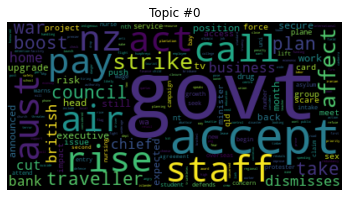

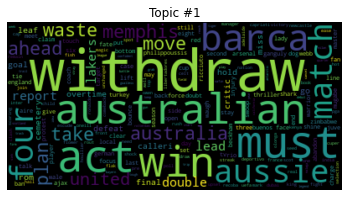

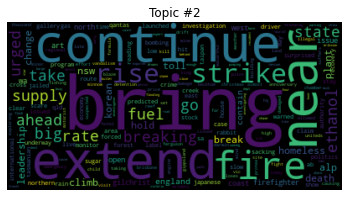

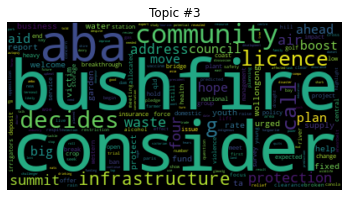

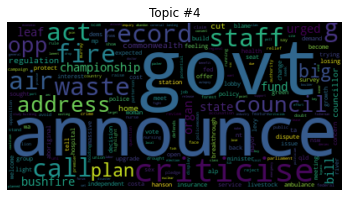

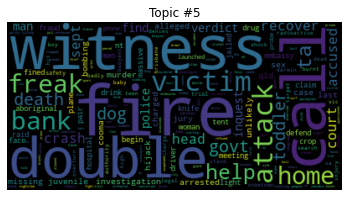

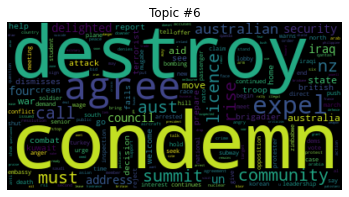

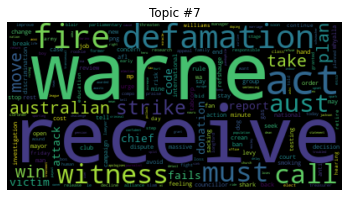

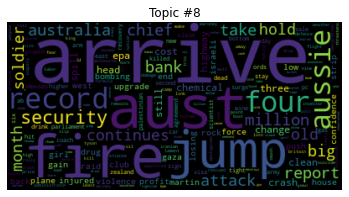

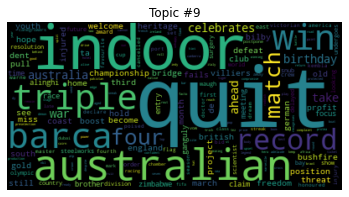

In [7]:
lda.print_topics()
perplexity=lda.compute_perplexity()
lda.plot_word_cloud(plt)

1000


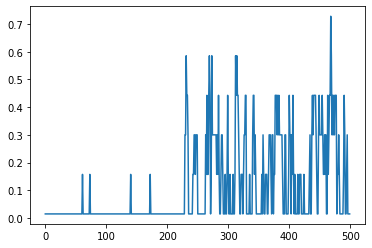

In [24]:
# print(topic_prob_list)
#
print(len(topic_prob_list))
# print(np.arange(len(topic_prob_list)))
topic_prob_list=np.array(topic_prob_list)
plt.plot(np.arange(500),topic_prob_list[:500,0])
plt.show()

Below code still in test, haven't got run

In [25]:
models=[]
perplexities=[]
models.append(lda)
perplexities.append(perplexity)
for topics in [20, 40, 60, 80, 100]:
    lda=LDA(documents=docs, vocabulary=dictionary, K=topics, max_iteration=1000)
    topic_prob_list=lda.execute()
    models.append(lda)
    perplexity=lda.compute_perplexity()
    perplexities.append(perplexity)

6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900
the perplexity of LDA with 20 topics is:510.11374707688714
6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900
the perplexity of LDA with 40 topics is:410.798367540005
6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900
the perplexity of LDA with 60 topics is:398.58062437761185
6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900
the perplexity of LDA with 80 topics is:390.3047131156943
6168
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iter

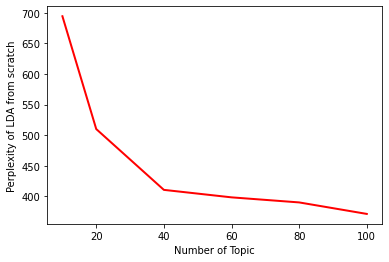

In [27]:
topics=[10, 20, 40, 60, 80,100]
plt.plot(topics,perplexities,color="red",linewidth=2)
plt.xlabel("Number of Topic")
plt.ylabel("Perplexity of LDA from scratch")
plt.show()

In [42]:

%matplotlib inline
# Because the log_perplexity showed in gensim is strange, not accord with our intuition, so we can use pyLDAvis to visualize the model 
from IPython.core.display import HTML
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
</style>'
doc_lens=[len(d) for d in models[0].documents]
# print(doc_lens)
term_frequency=np.squeeze(np.sum(models[0].topics_words,axis=0,keepdims=True))
topic_term=models[0].topics_words/np.sum(models[0].topics_words,axis=1,keepdims=True)
documents_topics=models[0].documents_topics/np.sum(models[0].documents_topics,axis=1,keepdims=True)
# print(term_frequency)
display(HTML(css_str ))
pyLDAvis.enable_notebook()
vis=pyLDAvis.prepare(topic_term,documents_topics,doc_lens,models[0].vocabulary,term_frequency)
pyLDAvis.save_html(vis, 'new.html')
pyLDAvis.display(vis)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [16]:
simu_data=pd.read_excel("simulation data.xlsx",  names = ['title','content'])
simu_data['all']=simu_data['title']+' '+simu_data['content']


In [17]:
cleanedData = []
# print(data)
lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in simu_data['all']:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]

    
    cleanedData.append(text)
# print(cleanedData)

dictionary = corpora.Dictionary(cleanedData)
# print(dictionary)
# print(cleanedData)
corpus = [dictionary.doc2bow(text) for text in cleanedData]

present_words=[]
docs = []
for doc in corpus:
    present_words=[]
    for j in doc:
        present_words.append(j[0])
    docs.append(present_words)
# print(docs)

In [23]:
lda_for_simu=LDA(documents=docs, vocabulary=dictionary, K=5, max_iteration=1000)
topic_prob_list=lda_for_simu.execute()

427
iteration is:0
iteration is:100
iteration is:200
iteration is:300
iteration is:400
iteration is:500
iteration is:600
iteration is:700
iteration is:800
iteration is:900


topic 

0.015*share+0.022*learning+0.022*high+0.029*week+0.029*2+0.036*method+0.036*topic+0.036*tentative+0.036*outline+0.051*course

topic 

0.014*hastie+0.022*learning+0.022*james+0.022*textbook+0.022*use+0.029*statistical+0.029*book+0.051*main+0.051*material+0.065*reference

topic 

0.013*exam+0.013*site+0.02*online+0.02*conduct+0.02*uc+0.027*must+0.027*davis+0.034*honesty+0.034*code+0.054*academic

topic 

0.021*regarding+0.021*email+0.021*may+0.028*answer+0.028*post+0.028*course+0.028*student+0.041*please+0.048*note+0.048*question

topic 

0.017*directly+0.017*deadline+0.017*5+0.025*zoom+0.025*piazza+0.025*report+0.042*office+0.05*ta+0.05*homework+0.05*hour

the perplexity of LDA with 5 topics is:112.49015703307349


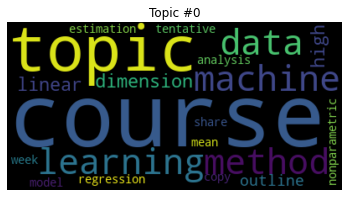

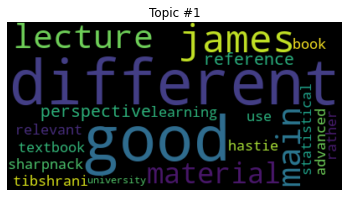

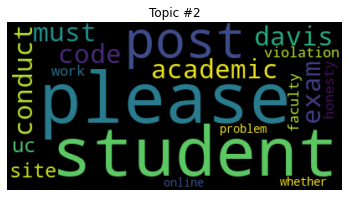

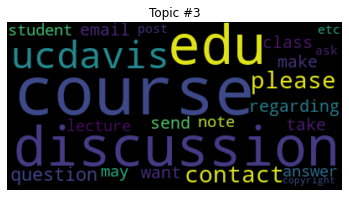

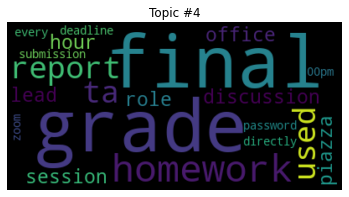

In [24]:
lda_for_simu.print_topics()
perplexity=lda_for_simu.compute_perplexity()
lda_for_simu.plot_word_cloud(plt)

In [25]:

%matplotlib inline
# Because the log_perplexity showed in gensim is strange, not accord with our intuition, so we can use pyLDAvis to visualize the model 
from IPython.core.display import HTML
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
</style>'
doc_lens=[len(d) for d in lda_for_simu.documents]
# print(doc_lens)
term_frequency=np.squeeze(np.sum(lda_for_simu.topics_words,axis=0,keepdims=True))
topic_term=lda_for_simu.topics_words/np.sum(lda_for_simu.topics_words,axis=1,keepdims=True)
documents_topics=lda_for_simu.documents_topics/np.sum(lda_for_simu.documents_topics,axis=1,keepdims=True)
# print(term_frequency)
display(HTML(css_str ))
pyLDAvis.enable_notebook()
vis=pyLDAvis.prepare(topic_term,documents_topics,doc_lens,lda_for_simu.vocabulary,term_frequency)
pyLDAvis.save_html(vis, 'simuFromscratch.html')
pyLDAvis.display(vis)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
